In [1]:
# We will need some functionality 
from typing import List 

import time

# and from math related libraries
import qutip as qt

import matplotlib.pyplot as plt

# and from qiskit
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Operator

import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z

from qiskit.utils.mitigation import CompleteMeasFitter

from qiskit.circuit import Parameter

import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()

from ipynb.fs.full.da_vqe import analog_ansatz, get_conv_time, get_eigenvalue, get_ham_operator, get_ham_operator, plot_connectivity, get_connections_matrix, digital_ansatz

<ipython-input-1-f0190094edbb>:34: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo


In [2]:
# noise_model = None
# device = QasmSimulator.from_backend(device_backend)
# coupling_map = device.configuration().coupling_map
# noise_model = NoiseModel.from_backend(device)
# basis_gates = noise_model.basis_gates

     ┌────────┐┌────────┐     ┌───┐ ░ 
q_0: ┤ Rx(a0) ├┤ Rz(b0) ├──■──┤ X ├─░─
     ├────────┤└────────┘┌─┴─┐└─┬─┘ ░ 
q_1: ┤ Rz(b1) ├──────────┤ X ├──■───░─
     └────────┘          └───┘      ░ 
Digital Eigenvalue 1.0662954190509926, Conv Time 0.9950124688279302


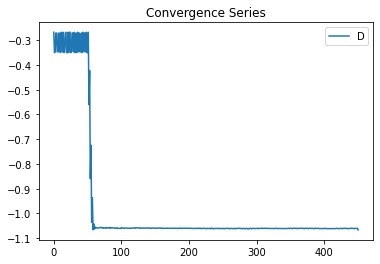

     ┌────────┐┌────────┐     ┌───┐┌────────┐┌────────┐     ┌───┐┌────────┐»
q_0: ┤ Rx(a0) ├┤ Rz(b0) ├──■──┤ X ├┤ Rx(a0) ├┤ Rz(b0) ├──■──┤ X ├┤ Rx(a0) ├»
     ├────────┤└────────┘┌─┴─┐└─┬─┘├────────┤└────────┘┌─┴─┐└─┬─┘├────────┤»
q_1: ┤ Rz(b1) ├──────────┤ X ├──■──┤ Rz(b1) ├──────────┤ X ├──■──┤ Rz(b1) ├»
     └────────┘          └───┘     └────────┘          └───┘     └────────┘»
«     ┌────────┐     ┌───┐ ░ 
«q_0: ┤ Rz(b0) ├──■──┤ X ├─░─
«     └────────┘┌─┴─┐└─┬─┘ ░ 
«q_1: ──────────┤ X ├──■───░─
«               └───┘      ░ 
Digital Eigenvalue 1.42719147007911, Conv Time 0.9950124688279302


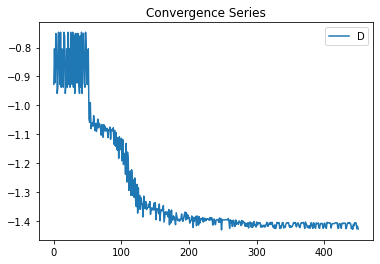

     ┌────────┐┌────────┐     ┌───┐┌────────┐┌────────┐     ┌───┐┌────────┐»
q_0: ┤ Rx(a0) ├┤ Rz(b0) ├──■──┤ X ├┤ Rx(a0) ├┤ Rz(b0) ├──■──┤ X ├┤ Rx(a0) ├»
     ├────────┤└────────┘┌─┴─┐└─┬─┘├────────┤└────────┘┌─┴─┐└─┬─┘├────────┤»
q_1: ┤ Rz(b1) ├──────────┤ X ├──■──┤ Rz(b1) ├──────────┤ X ├──■──┤ Rz(b1) ├»
     └────────┘          └───┘     └────────┘          └───┘     └────────┘»
«     ┌────────┐     ┌───┐┌────────┐┌────────┐     ┌───┐┌────────┐┌────────┐»
«q_0: ┤ Rz(b0) ├──■──┤ X ├┤ Rx(a0) ├┤ Rz(b0) ├──■──┤ X ├┤ Rx(a0) ├┤ Rz(b0) ├»
«     └────────┘┌─┴─┐└─┬─┘├────────┤└────────┘┌─┴─┐└─┬─┘├────────┤└────────┘»
«q_1: ──────────┤ X ├──■──┤ Rz(b1) ├──────────┤ X ├──■──┤ Rz(b1) ├──────────»
«               └───┘     └────────┘          └───┘     └────────┘          »
«          ┌───┐ ░ 
«q_0: ──■──┤ X ├─░─
«     ┌─┴─┐└─┬─┘ ░ 
«q_1: ┤ X ├──■───░─
«     └───┘      ░ 
Digital Eigenvalue 1.5322996578571741, Conv Time 0.9950124688279302


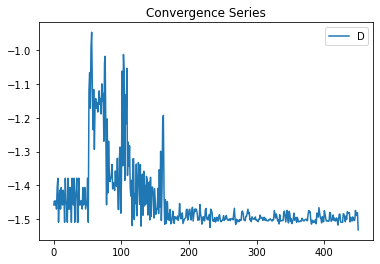

In [3]:
H2_op = (-1.052373245772859 * I ^ I) + (0.39793742484318045 * I ^ Z) + (-0.39793742484318045 * Z ^ I) + (-0.01128010425623538 * Z ^ Z) + (0.18093119978423156 * X ^ X)
ham_block = HamiltonianGate(data=H2_op, time=2)
chosen_op = H2_op

qubits_count = 2

seed = 170
iterations = 200
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed) 
#qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                         #coupling_map=coupling_map, noise_model=noise_model, 
                         #measurement_error_mitigation_cls=CompleteMeasFitter, 
                         #cals_matrix_refresh_period=30)

for blocks in [1,3,5]:
    printing = True
    #ana_dats = get_eigenvalue("analog",qubits_count,chosen_op,qi,iterations,blocks,ham_block,printing)
    dig_dats = get_eigenvalue("digital",qubits_count,chosen_op,qi,iterations,blocks,ham_block,printing)

    #print("Analog Eigenvalue {},".format(ana_dats[0]),"Conv Time {}".format(ana_dats[2]))
    print("Digital Eigenvalue {},".format(dig_dats[0]),"Conv Time {}".format(dig_dats[2]))
    #plt.plot(ana_dats[1],label="A")
    plt.plot(dig_dats[1],label="D")
    plt.legend()
    plt.title("Convergence Series")
    plt.show()